import stuff

In [2]:
from dotenv import load_dotenv
import sys
sys.path.append("../../")
from shared.models import MiniPileDataset
from shared.contra import BottleneckT5Autoencoder
from shared.interp import count_non_zero_feature_activations, plot_feature_activation_histogram
from shared.features import Feature, FeatureSample
import os
import json
import torch

# Enable automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2


# Load environment variables from .env file
load_dotenv()

# Access the OpenAI API key from the environment variables
openai_api_key = os.getenv("OPENAI_API_KEY")


/piech/u/joetey/auto-ed-coder/venv/lib/python3.10/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_mutation' has been removed
  warnings.warn(message, UserWarning)


In [3]:
folder = "../training_sae/saes/contra_3_20241014_084411"

In [4]:
# Load the model from the pickle file
import pickle 
import sys
import os

from shared.sparse_autoencoder import SparseAutoencoder, SparseAutoencoderConfig
import json

# load the dataset
sentences_file = "../data_preparation/chunking/chunked_datasets/JeanKaddour_minipile.csv"
embeddings_file = "../data_preparation/embedding_chunks/embedded_chunks/contra_minipile_20241014_002936/embeddings.npy"
mini_pile_dataset = MiniPileDataset(sentences_file, embeddings_file)

# Load the configuration from the JSON file
config_path = os.path.join(folder, 'config.json')
with open(config_path, "r") as config_file:
    config = json.load(config_file)

# Load the pre-trained model from the pickle file
sae_config = SparseAutoencoderConfig(d_model=config["dimensions"], d_sparse=8 * config["dimensions"], sparsity_alpha=config["sparsity_alpha"])
model = SparseAutoencoder(sae_config)

with open(os.path.join(folder, 'sae.pkl'), "rb") as f:
    model_state_dict = pickle.load(f)
    model.load_state_dict(model_state_dict)

In [5]:
# Load the log feature densities from the JSON file
log_feature_densities_path = os.path.join(folder, "log_feature_densities.json")
with open(log_feature_densities_path, "r") as json_file:
    log_feature_densities = json.load(json_file)

print("Log feature densities loaded successfully.")


Log feature densities loaded successfully.


interpret the feature activations

len(filtered_feature_activations) 5618


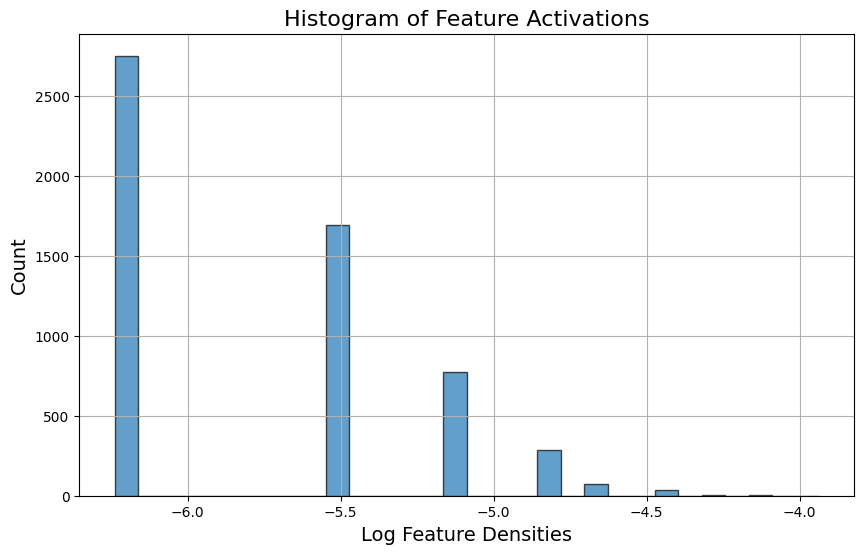

In [7]:
training_step = len(log_feature_densities) - 5
feature_activations = log_feature_densities[training_step]

# Filter out -inf values
filtered_feature_activations = [fa for fa in feature_activations if fa != -float('inf')]
print("len(filtered_feature_activations)", len(filtered_feature_activations))

import matplotlib.pyplot as plt

# Plotting the histogram of feature activations
plt.figure(figsize=(10, 6))
plt.hist(filtered_feature_activations, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Log Feature Densities", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Histogram of Feature Activations", fontsize=16)
plt.grid(True)
plt.show()


In [11]:
len(mini_pile_dataset)

1022330

In [8]:
count_non_zero_feature_activations(model, mini_pile_dataset, 1000)

Average Non-Zero Elements for first 1000 samples: 16.018999099731445
Average Percentage of Non-Zero Elements: 0.20%


In [ ]:
plot_feature_activation_histogram(model, mini_pile_dataset)

automated interp pipeline: analysis

In [3]:
import os
import json

features_folder = "../feature_extraction/features/20241013_234644"
features = []
filtered_out_count = 0

for filename in os.listdir(features_folder):
    if filename.startswith("feature_") and filename.endswith(".json"):
        with open(os.path.join(features_folder, filename), "r") as json_file:
            feature_data = json.load(json_file)
            feature = Feature(**feature_data)
            if len(feature.high_act_samples) >= 10:
                features.append(feature)
            else:
                filtered_out_count += 1

features.sort(key=lambda x: x.confidence, reverse=True)

print(f"Number of filtered out samples: {filtered_out_count}")

Number of filtered out samples: 0


In [5]:
for feature in features[:200]:
    print(f"Index: {feature.index}, Label: {feature.label}, Confidence: {feature.confidence}")

Index: 7, Label: In-depth analyses and discussions, Confidence: 52.0
Index: 80, Label: Complex narrative style, Confidence: 48.0
Index: 73, Label: Complex and informative sentence structures, Confidence: 43.0
Index: 79, Label: Informative and structured language, Confidence: 43.0
Index: 58, Label: Use of formal academic language, Confidence: 40.0
Index: 24, Label: Scientific language and analysis, Confidence: 39.0
Index: 35, Label: Complexity in ideas and details, Confidence: 37.0
Index: 81, Label: Scientific and analytical language, Confidence: 36.0
Index: 28, Label: Coherent and structured narratives, Confidence: 35.0
Index: 63, Label: Narrative and emotional context, Confidence: 33.0
Index: 64, Label: Informative and analytical content, Confidence: 30.0
Index: 57, Label: Complex and detailed content, Confidence: 30.0
Index: 31, Label: Formal and structured content, Confidence: 30.0
Index: 45, Label: Complex and expressive language, Confidence: 28.0
Index: 92, Label: Narrative and ex

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
autoencoder = BottleneckT5Autoencoder(model_path='thesephist/contra-bottleneck-t5-base-wikipedia', device=device)

In [22]:
# Ensure the model is on the correct device
model = model.to(device)

t = "The theatre has undergone several updates before its move from the Dramacor by British Film Commission"
feature_index = 7

embedding = autoencoder.embed(t)
# Move the embedding to the same device as the model
embedding = embedding.to(device)

feature_activations = model.forward(embedding)[1]

feature_activations[feature_index]

tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)

In [23]:
feature_activations[feature_index] = 20

reconstruction = autoencoder.generate_from_latent(model.decode(feature_activations))

print(reconstruction)

from the previous round (for the match between the teams), and
